<a href="https://colab.research.google.com/github/urmzd/md-nlp/blob/main/src/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install pyppeteer
!pip install ipython ipykernel --upgrade

In [83]:
!apt-get update 
!apt-get install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!dpkg -L chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-back

In [84]:
import random
from numpy import random as nprd
import tensorflow as tf
tf.random.set_seed(42)
random.seed(42)
nprd.seed(42)

In [85]:
import asyncio
import re
import csv
import pyppeteer as ptr
import pandas as pd
import nltk
from typing import Optional, TypeVar
from typing import Callable
from glob import glob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [88]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
!pip show gensim
!pip install -U gensim

Name: gensim
Version: 4.1.2
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, smart-open, numpy
Required-by: 


In [91]:
resource_path = "/content/drive/MyDrive/resources/"

data_path = resource_path + "data/"
data_source_path = data_path + "sources/"
data_target_path = data_path + "targets/"

corpus_name = "corpus"

In [92]:
global_config = {
    "word_limit": 56,
    "n_samples": 1000,
    "test_size": 0.2
}

In [93]:
from typing import Tuple
def get_name_and_extension(file_path: str) -> Tuple[str, str]:
    regex = re.compile(r"(.*)/(.*)\.(.*)")
    return regex.match(file_path).group(2,3)

In [94]:
!curl -sSL https://dl.google.com/linux/linux_signing_key.pub | apt-key add -
!echo "deb [arch=amd64] https://dl.google.com/linux/chrome/deb/ stable main" > /etc/apt/sources.list.d/google-chrome.list
!apt update -y && apt install -y google-chrome-stable

OK
Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-b

In [95]:
# scraper.py
from pyppeteer import launch, browser
from typing import Union, List, Callable, Tuple, TypeVar
from nltk import tokenize,data
from glob import glob
import csv
import re
import pickle

# Declare Types.
Url = str
Selector = str
Html = str

ProcessedText = List[str]
Processor = TypeVar('Processor', Callable[[Html], ProcessedText], None)

def tokenize_by_sentence(html: str) -> ProcessedText:
  sent_detector = data.load('tokenizers/punkt/english.pickle')
  return sent_detector.tokenize(html)

def replace_all_new_lines(texts: ProcessedText) -> ProcessedText:
  return [re.sub('\n', ' ', text) for text in texts]

def pipeline(*transformers):
  fns = [*transformers]
  def pipeline_inner(input, fns=transformers):
    head, *tail = fns
    new_input = head(input)
    if tail:
      return pipeline_inner(new_input, tail)

    return new_input
  
  return pipeline_inner

def write_to_resource_target(target_path: str, file_name: str, content: ProcessedText, extension=".txt", mode="w") -> None:
    with open(f"{target_path}{file_name}{extension}", mode) as file:
        file.write("\n".join(content))

# Core
async def scraper() -> Tuple[Callable[[Url, Selector, Processor], ProcessedText], browser.Browser]:
  browser = await launch(
        executablePath="/usr/bin/chromium-browser", 
        args= ['--no-sandbox']
  )

  async def inner_download_html(url: Url, selector: Selector, processor: Processor = None) -> ProcessedText:
    page = await browser.newPage()
    await page.goto(url, waitUntil="load", timeout=0)
    print(f"Going to collect from {url} using selector {selector}")
    content = await page.querySelector(selector)

    html = ''
    if content:
        html = await page.evaluate('(element) => element.textContent', content)
    
    if processor:
      return processor(html)

    return [html]
  
  return (inner_download_html, browser)

async def get_training_data_from_folder(source_path: str, target_path: str, force=False) -> None:
    glob_pattern = "/**/*"
    source_files = glob(source_path + glob_pattern, recursive=True)
    target_files = glob(target_path + glob_pattern, recursive=True)
    target_file_names = [get_name_and_extension(file_path)[0] for file_path in target_files]
    
    download_html, browser = await scraper() 

    for file_path in source_files:
        [file_name, file_extension] = get_name_and_extension(file_path)

        if not file_name in target_file_names or force:
            with open(file_path, 'r') as file:
              articles = csv.DictReader(file)
              for article in articles:
                print(article)
                url, selector = article['link'], article['selector']
                result = await download_html(url, selector, pipeline(tokenize_by_sentence, replace_all_new_lines))
                write_to_resource_target(target_path, file_name, result)    
                write_to_resource_target(data_path, corpus_name, result, mode="a")    
                
    if browser:
      await browser.close()

In [96]:
await get_training_data_from_folder(data_source_path, data_target_path)

In [97]:
from pprint import pprint as print
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath
from typing import Optional
from gensim.test.utils import get_tmpfile
import numpy as np

model_path = resource_path + "models/"
fast_text_path = model_path + "fast_text.model"

def load_fast_text() -> FastText:
  try:
    return FastText.load(fast_text_path)
  except:
    return train_fast_text()

def save_fast_text(model: FastText, force=True) -> None:
  if force:
    tmp_file = get_tmpfile(fast_text_path)
    model.save(tmp_file)

def train_fast_text() -> FastText:  
  model = FastText(vector_size=32)
  corpus_path = glob(data_path + "corpus.*")[0]
  model.build_vocab(corpus_file=corpus_path)

  model.train(
      corpus_file=corpus_path, epochs=model.epochs,
      total_examples=model.corpus_count, total_words=model.corpus_total_words,
  )
  
  save_fast_text(model)

  return model

fast_text_model = train_fast_text()
# print(fast_text_model.wv.most_similar("stiff"))
# np.copy(fast_text_model.wv['Urmzd'])

In [98]:
# deprecated
# Functions used to tokenize, filter and map words.
# T = TypeVar("T")
# R = TypeVar("R")

# from typing import List, Tuple
# PosTag = Tuple[str, str]
# PosTagList = List[PosTag]
# StemWord = str
# StemWordList = List[StemWord]

# TestValueStrCallable = Callable[[T], str]
# TestValueBoolCallable = Callable[[T], bool]
# ValueTestFnCallable = Callable[[T], TestValueStrCallable]
# FilterCallable = Callable[[ValueTestFnCallable], bool]
# MapCallable = Callable[[ValueTestFnCallable], str]

# def tokenize(data: str) -> PosTagList:
#     tokenized_words = nltk.word_tokenize(data)
#     mutated_words = nltk.pos_tag(tokenized_words)
#     return mutated_words

# def filter_words(x: T, test_value: TestValueStrCallable, *fns: FilterCallable) -> bool:
#     if fns:
#         if fns[0](x, test_value):
#             return filter_words(x, test_value, *fns[1:])
#         else:
#             return False
    
#     return True
    
# def filter_by_punctuation(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
#     return x[0] != x[1]

# def filter_by_stop_word(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
#     return test_value(x) not in stopwords.words("english")

# def regex_filter(regex: str):
#     def filter_by_regex(x: T, test_value: TestValueStrCallable = lambda t: t[0]):
#         rgx = re.compile(regex)
#         return rgx.match(test_value(x))
#     return filter_by_regex

# filter_by_alphabet = regex_filter(r"^([a-zA-Z]|')+$")
# filter_by_apostrophe = regex_filter(r"^[^']*$")

# def map_by_stem_words(x: PosTag, test_value: TestValueStrCallable = lambda t: t[0], ps=PorterStemmer()) -> StemWord:
#     return ps.stem(test_value(x)).lower()

# def map_words(x: T, test_value: TestValueStrCallable, *fns: MapCallable) -> StemWord:
#     if fns:
#         return map_words(fns[0](test_value(x)), test_value, *fns[1:])

#     return x
            
# def clean_up_words(words: PosTagList) -> StemWordList:
#     filtered_words = list(set(
#         filter(
#         lambda x: filter_words(x, lambda x: x[0], filter_by_punctuation, filter_by_stop_word, filter_by_alphabet),
#         words
#         )
#     ))

#     stem_words = list(set(map(lambda x: map_words(x, lambda x: x, map_by_stem_words), filtered_words)))
    
#     return list(set(
#         filter(
#             lambda x: filter_words(x, lambda x: x, filter_by_apostrophe), 
#             stem_words)
#     ))

In [99]:
# Deprecate.
# from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
# from typing import Union

# def get_one_hot_encoder(population: Dict[str, StemWordList]):
#     population_array = np.array(list(set(unpack_dict_list(population)))).reshape(-1, 1)
#     encoder = OneHotEncoder(handle_unknown='ignore')
#     encoder.fit(population_array)
#     return encoder

import pickle
import os
from glob import glob
from sklearn.preprocessing import LabelBinarizer

model_label_encoder = model_path + "label_encoder.pickle"

def save_label_encoder(label_encoder: LabelBinarizer, file_name: str = model_label_encoder) -> None:
    pickle.dump(label_encoder, open(file_name, "wb"))

def load_label_encoder(file_name: str = model_label_encoder) -> Optional[LabelBinarizer]:
    if os.path.exists(file_name):
      return pickle.load(open(file_name, "rb"))

    target_names = [get_name_and_extension(file_path)[0] for file_path in glob(data_target_path + "*", recursive=True)]
    return train_label_encoder(target_names, True)

def train_label_encoder(labels: List[str], force=False):
    if force:
      encoder = LabelBinarizer()
      encoder.fit(labels)
      save_label_encoder(encoder)
      return encoder
    return load_label_encoder()

# def transform_data_by_encoder(data: np.ndarray, encoder: Union[OneHotEncoder, LabelBinarizer]):
#     encoded_data = encoder.transform(data)
    
#     if not isinstance(encoded_data, np.ndarray):
#         encoded_data = encoded_data.toarray()
        
#     return encoded_data

# def split_into_x_y(samples: np.ndarray):
#     x = samples[:,:,:-1]
#     y = samples[:,:,-1]
#     y = y.reshape(y.shape[0]*y.shape[1], 1)
#     return (x,y)
    
# def transform_x_y(x: np.ndarray, y: np.ndarray, in_coder: OneHotEncoder, out_coder: LabelBinarizer):   
#     encoded_x = np.stack([
#         transform_data_by_encoder(x[lbl_idx, smpl_idx], in_coder)
#         for lbl_idx in range(x.shape[0])
#         for smpl_idx in range(x.shape[1])
#     ], axis=0)
            
#     encoded_y = transform_data_by_encoder(y, out_coder)
    
#     return (encoded_x, encoded_y)

In [100]:
from typing import Dict

def unpack_dict_list(dict_list: Dict[str, ProcessedText]):
    return [v for k in dict_list for v in dict_list[k]]

def get_cleaned_data_from_file(input_file_path: str):
    with open(input_file_path, "r") as file:
        return [sentence.strip("\n") for sentence in list(file.readlines())]

def get_cleaned_data_from_folder(input_path: str):
    glob_pattern = "/**/*"
    input_files = glob(input_path + glob_pattern, recursive=True)
    
    data = dict()
    for file_path in input_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        classification_data = get_cleaned_data_from_file(file_path)
        data[file_name] = classification_data
        
    return data

In [101]:
# Deprecated.
# from nltk.probability import WittenBellProbDist, FreqDist,LaplaceProbDist
# import numpy as np

# def generate_sample(population: StemWordList, label: str, n_unique_words: int, word_limit = global_config["word_limit"]):
#     freq_dist = FreqDist(population)
#     prob_dist = WittenBellProbDist(freq_dist, n_unique_words)
    
#     samples = [prob_dist.generate() for _ in range(word_limit)]

#     return np.array(list([*samples, label])).reshape(-1, 1)

# def generate_samples(data: Dict[str, StemWordList], n_samples = global_config["n_samples"]):
#     n_unique_words = len(set(unpack_dict_list(data)))
    
#     return np.array([np.array([generate_sample(data[k], k, n_unique_words) for _ in range(n_samples)]) for k in data])

In [112]:
import pickle
import numpy as np
from nltk import tokenize

def pad_sequence(sequence: np.ndarray, limit=56) -> np.ndarray:
  _sequence = np.copy(sequence)

  if _sequence.shape[0] == limit:
    return _sequence

  paddings = []

  if _sequence.shape[0] < limit:
    mins = np.minimum.reduce(_sequence)
    maxs = np.maximum.reduce(_sequence)
    for i in range(limit - _sequence.shape[0]):
      if i // 2:
        paddings.append(mins)
      else:
        paddings.append(maxs)
    
    return np.vstack((_sequence, paddings))

  return _sequence[:limit]
  
def get_x_y_from_sentence(sentence: str, label: str = None, x_encoder: FastText = load_fast_text(), y_encoder: LabelBinarizer = load_label_encoder(), word_limit=56) -> Tuple[np.ndarray, np.ndarray]:
  x = np.vstack([x_encoder.wv[text] for text in tokenize.wordpunct_tokenize(sentence)])
  padded_x = pad_sequence(x, word_limit)
  padded_x = padded_x.reshape((*padded_x.shape, 1))
  if label:
    y = y_encoder.transform([label])
  else:
    y = None

  return (padded_x, y)

def get_x_y(path = data_target_path):
    result = get_cleaned_data_from_folder(data_target_path)
    xs = []
    ys = []

    for label, sentences in result.items():
      for sentence in sentences:
        x, y = get_x_y_from_sentence(sentence, label)
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.vstack(ys)

In [108]:
from functools import lru_cache 

@lru_cache(maxsize=2)
def get_data(test_size=global_config["test_size"], random_state=42, ignore=False):
    if ignore:
      return [None, None, None, None]

    x, y = get_x_y()
    print((x.shape, y.shape, "GET_DATA"))
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

In [109]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers, activations

cnn_folder = "cnn"
cnn_path = model_path + cnn_folder

def save_cnn(model: keras.Model):
  model.save(cnn_path)

def load_cnn(retrain=False) -> keras.Model:
  if os.path.exists(cnn_path) and not retrain:
    return keras.models.load_model(cnn_path)

  return train_cnn(*get_data())

In [160]:
history_path = model_path + "history.npy"

def save_history(history: np.ndarray):
  np.save(history_path, history, allow_pickle=True)

def load_history() -> Dict:
  if os.path.exists(history_path):
    return np.load(history_path, allow_pickle=True).item()

  return {}

def train_cnn(x_train, x_test, y_train, y_test):
    input_shape = x_train.shape[1:]

    print((input_shape, y_train.shape, y_test.shape))
    config = {}

    config["conv_layer_0"] = {
        "filters": 1,
        "kernel_size": (2, 2),
        "strides": (1,1),
        "activation": "relu",
    }

    config["pool_layer_0"] = {
        "pool_size": (1,1),
        "padding": "same"
    }

    config["conv_layer_1"] = {
        "filters": 1,
        "kernel_size": (1, 1),
        "strides": (1,1),
        "activation": "relu"
    }

    config["pool_layer_1"] = {
        "pool_size": (1,1),
        "padding": "same",
    }

    config["dense_layer_5"] = {
        "units": 32,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0, 17e-1)
    }

    config["dense_layer_6"] = {
        "units": 16,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0, 18e-1)
    }

    config["dense_layer_7"] = {
        "units": 8,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(0, 12e-1),
        "bias_regularizer": regularizers.l1_l2(0, 1e-11)
    }

    config["dropout_layer_0"] = {
        "rate": 0.22,
    }

    config["dense_layer_8"]= {
        "units": 8,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(0, 4e-7),
        "bias_regularizer": regularizers.l1_l2(0, 9e-1)
    }

    config["dropout_layer_1"]= {
        "rate": 0.33
    }

    config["flatten_layer_0"] = {
    }

    config["dense_layer_final"] = {
        "units": (y_train.shape[-1]),
        "activation": "sigmoid"
    }

    config["model_compile"] = {
        "optimizer": tf.keras.optimizers.Adam(0.001),
        "loss": keras.losses.binary_crossentropy,
        "metrics": ["accuracy", keras.metrics.Recall()]
    }

    config["model_fit"] = {
         "x": x_train,
         "y": y_train,
         "batch_size": 2,
         "epochs": 8,
         "validation_split" : global_config["test_size"]
    }

    encoder_input = keras.Input(shape=input_shape)
    prev_layer = encoder_input
    encoder_output=None

    layer_types = {
        "dense": layers.Dense,
        "flatten": layers.Flatten,
        "dropout": layers.Dropout,
        "conv": layers.Conv2D,
        "pool": layers.MaxPool2D,
        "comp": None,
    }
    
    for k,v in config.items():
      type_of_layer, *_ = k.split("_")
      if type_of_layer != "model":
        encoder_output = layer_types[type_of_layer](**v)(prev_layer)
        prev_layer = encoder_output
    
    config["model"] = {
        "inputs": encoder_input,
        "outputs": encoder_output,
        "name": "encoder"
    }

    model = keras.Model(**config["model"])
    model.compile(**config["model_compile"])

    print(model.summary())
    
    history = model.fit(**config["model_fit"])
    save_cnn(model)
    save_history(history.history)

    test_scores = model.evaluate(x_test, y_test, verbose=2)

    return model    

In [161]:
model = load_cnn(retrain=True)

((56, 32, 1), (159, 3), (40, 3))
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 56, 32, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 55, 31, 1)         5         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 55, 31, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 55, 31, 1)         2         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 55, 31, 1)        0         
 g2D)                                                            
                                                                 
 dense_35 (Dense)         

In [162]:
def clean_up_user_input(sentence: str):  
  x,_ = get_x_y_from_sentence(sentence)

  return x

dict_keys(['loss', 'accuracy', 'recall_7', 'val_loss', 'val_accuracy', 'val_recall_7'])


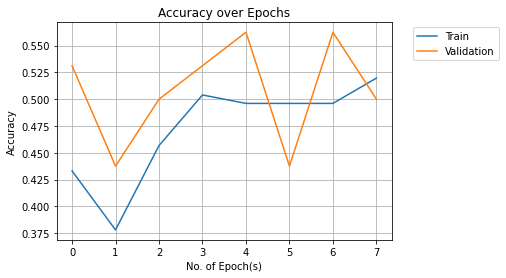

dict_keys(['loss', 'accuracy', 'recall_7', 'val_loss', 'val_accuracy', 'val_recall_7'])


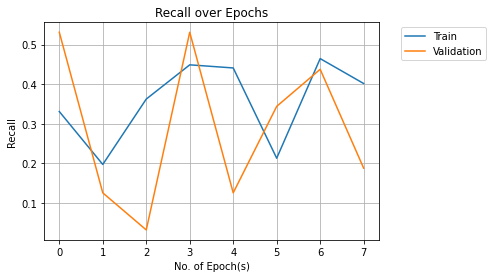

In [163]:
from keras import models
from matplotlib import pyplot as plt

graph_path = resource_path + "graphs/"

def plot_cnn(metric:str):
  history = load_history()
  print(history.keys())
  regex = re.compile(fr'{metric}.*$')
  metrics = list(filter(regex.search, history.keys()))
  training_metric, val_metric = metrics
  name, *_ = training_metric.split("_")
  fig, ax = plt.subplots()
  ax.plot(history[training_metric])
  ax.plot(history[val_metric])
  ax.set_title(f'{name.title()} over Epochs')
  ax.set_ylabel(name.title())
  ax.set_xlabel('No. of Epoch(s)')
  ax.grid()
  legend = ax.legend(['Train', 'Validation'], bbox_to_anchor=(1.05, 1))

  os.makedirs(graph_path, exist_ok=True)
  fig.savefig(graph_path + metric, bbox_extra_artists=[legend], bbox_inches='tight')

  plt.show()


plot_cnn("accuracy")
plot_cnn("recall")

In [164]:
def predict(sentence: str):
  encoded_word = clean_up_user_input(sentence)
  encoded_word = np.array([encoded_word])

  output_encoder: LabelBinarizer = load_label_encoder()
  prediction = model.predict(encoded_word)
  prediction_binary = np.zeros_like(prediction)
  prediction_binary[:,prediction.argmax(1)] = 1
  print(prediction)
  ailment:str = output_encoder.inverse_transform(prediction)[0]
  return ailment.upper()

fast_text = load_fast_text()
print((fast_text.wv.most_similar("headache", topn=30)))

[('headache".', 0.9995860457420349),
 ('headaches?', 0.999329149723053),
 ('headaches;', 0.9992431402206421),
 ('headache:', 0.9991653561592102),
 ('headache.', 0.9991124868392944),
 ('headaches:', 0.998340368270874),
 ('headaches".', 0.9981985092163086),
 ('headache,', 0.9981157183647156),
 ('headaches', 0.9973040819168091),
 ('headaches.', 0.9964399337768555),
 ('head)', 0.9918993711471558),
 ('head', 0.9893831610679626),
 ('headaches,', 0.9886679649353027),
 ('head,', 0.98702472448349),
 ('head.', 0.986944854259491),
 ('pain', 0.9803731441497803),
 ('migraineurs', 0.9771416187286377),
 ('(migraine', 0.9771267175674438),
 ('depressed,', 0.9767941236495972),
 ('“migraine', 0.9764986038208008),
 ('depression.', 0.9764957427978516),
 ('depressed.', 0.9760173559188843),
 ('depression,', 0.9757803082466125),
 ('migraine', 0.9752934575080872),
 ('depression)', 0.9744929075241089),
 ('depression",', 0.97428297996521),
 ('depression?', 0.9740561842918396),
 ('seven,', 0.9736412167549133),
 (